<a href="https://colab.research.google.com/github/RYUKxAYU/internship_Assisment_1/blob/main/cognifyz_technology_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity


data = pd.read_csv('/content/Dataset .csv')


data['Cuisines_original'] = data['Cuisines']
data['Cuisines'] = data['Cuisines'].fillna('Unknown')
# Split cuisines into binary columns
cuisines = data['Cuisines'].str.get_dummies(', ')
data = pd.concat([data, cuisines], axis=1)

# Encode categorical variables
le = LabelEncoder()
data['City'] = le.fit_transform(data['City'])
data['Currency'] = le.fit_transform(data['Currency'])
data['Has Table booking'] = data['Has Table booking'].map({'Yes': 1, 'No': 0})
data['Has Online delivery'] = data['Has Online delivery'].map({'Yes': 1, 'No': 0})
data['Is delivering now'] = data['Is delivering now'].map({'Yes': 1, 'No': 0})
data['Switch to order menu'] = data['Switch to order menu'].map({'Yes': 1, 'No': 0})

# Drop irrelevant columns
data = data.drop(['Restaurant ID', 'Address', 'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Rating color', 'Votes'], axis=1)
if 'Cuisines' in data.columns:
    data = data.drop('Cuisines', axis=1)


# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ['Average Cost for two', 'Aggregate rating', 'Price range']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


# Recommendation function
def recommend_restaurants(preferences, data, le_city, scaler, top_n=5):
    exclude_cols = ['Restaurant Name', 'Cuisines_original', 'Rating text']
    feature_cols = [col for col in data.columns if col not in exclude_cols]
    user_vector = np.zeros(len(feature_cols))


    # Set cuisine preferences
    for cuisine in preferences.get('cuisines', []):
        if cuisine in feature_cols:
            user_vector[feature_cols.index(cuisine)] = 1

    dummy_numerical_values = np.zeros(len(numerical_cols))

    if preferences.get('price_range'):
        mid_price = sum(preferences['price_range']) / 2
        try:
            avg_cost_idx_numerical = numerical_cols.index('Average Cost for two')
            dummy_numerical_values[avg_cost_idx_numerical] = mid_price
        except ValueError:
             print("Warning: 'Average Cost for two' not found in numerical_cols.")

    min_rating = preferences.get('min_rating', 0)
    try:
        rating_idx_numerical = numerical_cols.index('Aggregate rating')
        dummy_numerical_values[rating_idx_numerical] = min_rating
    except ValueError:
        print("Warning: 'Aggregate rating' not found in numerical_cols.")

    price_range_lower = preferences.get('price_range', [0, 0])[0]
    try:
        price_range_idx_numerical = numerical_cols.index('Price range')
        dummy_numerical_values[price_range_idx_numerical] = price_range_lower
    except ValueError:
         print("Warning: 'Price range' not found in numerical_cols.")

    scaled_numerical_values = scaler.transform([dummy_numerical_values])[0]

    for i, col in enumerate(numerical_cols):
        if col in feature_cols:
             user_vector[feature_cols.index(col)] = scaled_numerical_values[i]


    if preferences.get('city') != 'any':
        try:
            city_encoded = le_city.transform([preferences['city']])[0]
            if 'City' in feature_cols:
                 user_vector[feature_cols.index('City')] = city_encoded
            else:
                print("Warning: 'City' not found in feature_cols.")
        except ValueError:
            if 'City' in feature_cols:
                user_vector[feature_cols.index('City')] = data['City'].mean()
            else:
                 print("Warning: 'City' not found in feature_cols.")
    else:
        if 'City' in feature_cols:
            user_vector[feature_cols.index('City')] = data['City'].mean()
        else:
             print("Warning: 'City' not found in feature_cols.")


    # Set binary preferences
    if preferences.get('has_table_booking'):
        if 'Has Table booking' in feature_cols:
            user_vector[feature_cols.index('Has Table booking')] = 1


    restaurant_vectors = data[feature_cols].to_numpy()
    similarities = cosine_similarity([user_vector], restaurant_vectors)[0]

    temp_data = data.copy()
    temp_data['Similarity'] = similarities
    recommendations = temp_data.sort_values(by='Similarity', ascending=False).head(top_n)


    display_cols = ['Restaurant Name', 'City', 'Cuisines_original', 'Average Cost for two', 'Aggregate rating', 'Price range', 'Similarity']
    display_cols = [col for col in display_cols if col in recommendations.columns]

    recommendations = recommendations[display_cols]


    return recommendations

# Test with sample preferences
print("=== Test 1: Japanese, budget, Makati City, rating >=4.0, table booking ===")
user_prefs1 = {
    'cuisines': ['Japanese', 'Sushi'],
    'price_range': [500, 1500],
    'city': 'Makati City',
    'min_rating': 4.0,
    'has_table_booking': True
}
recs1 = recommend_restaurants(user_prefs1, data, le, scaler)

if not recs1.empty:

    # Select the numerical columns from the recommendations
    recommendation_numerical_cols = [col for col in numerical_cols if col in recs1.columns]
    if recommendation_numerical_cols:
        recs1[recommendation_numerical_cols] = scaler.inverse_transform(recs1[recommendation_numerical_cols])

    if 'City' in recs1.columns and pd.api.types.is_integer_dtype(recs1['City']):
        recs1['City'] = le.inverse_transform(recs1['City'])
print(recs1)

print("\n=== Test 2: Italian, premium, any city, rating >=4.0 ===")
user_prefs2 = {
    'cuisines': ['Italian'],
    'price_range': [1500, 4000],
    'city': 'any',
    'min_rating': 4.0
}
recs2 = recommend_restaurants(user_prefs2, data, le, scaler)

# Reverse scaling for display
if not recs2.empty:
    recommendation_numerical_cols = [col for col in numerical_cols if col in recs2.columns]
    if recommendation_numerical_cols:
        recs2[recommendation_numerical_cols] = scaler.inverse_transform(recs2[recommendation_numerical_cols])

    if 'City' in recs2.columns and pd.api.types.is_integer_dtype(recs2['City']):
        recs2['City'] = le.inverse_transform(recs2['City'])
print(recs2)

=== Test 1: Japanese, budget, Makati City, rating >=4.0, table booking ===
                       Restaurant Name                City  \
631              Taj Bano - ITC Mughal  Brazilian Real(R$)   
633       Dawat-e-Nawab - Radisson Blu  Brazilian Real(R$)   
629                          MoMo Cafe  Brazilian Real(R$)   
630              Peshawri - ITC Mughal  Brazilian Real(R$)   
645  Patang - The Revolving Restaurant           Dollar($)   

                      Cuisines_original  Average Cost for two  \
631                             Mughlai                2500.0   
633               North Indian, Mughlai                3600.0   
629              North Indian, European                2000.0   
630               North Indian, Mughlai                2500.0   
645  Continental, Chinese, North Indian                1800.0   

     Aggregate rating  Price range  Similarity  
631               4.0          4.0    0.501892  
633               3.8          4.0    0.494195  
629           

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<ipython-input-2-e9d97e9c99fa>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


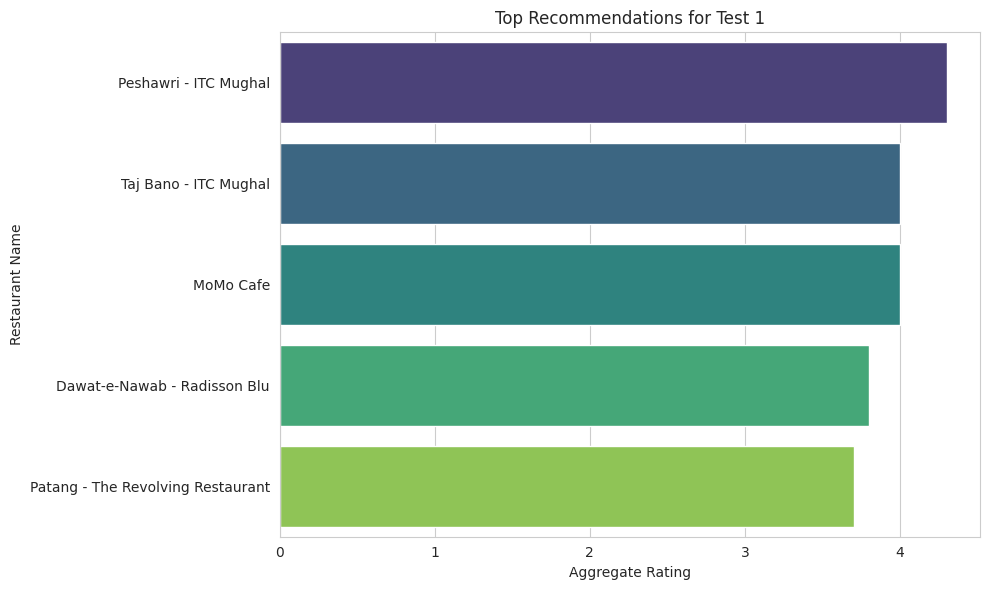

<ipython-input-2-e9d97e9c99fa>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


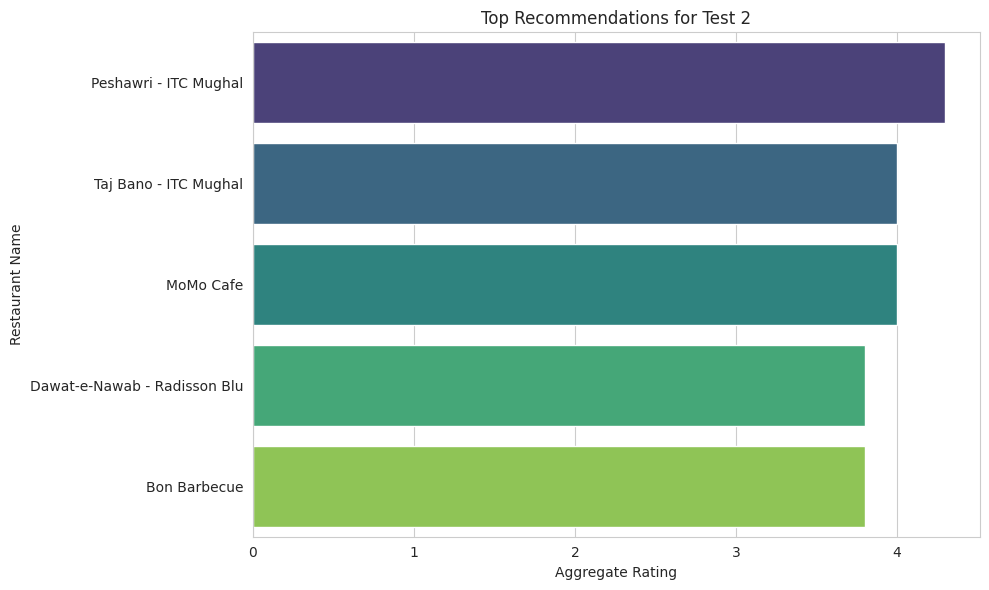

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_recommendations(recommendations, title="Top Recommendations"):
    if recommendations.empty:
        print("No recommendations to visualize.")
        return

    # Set figure size and style
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Plot
    ax = sns.barplot(
        x="Aggregate rating",
        y="Restaurant Name",
        data=recommendations.sort_values(by="Aggregate rating", ascending=False),
        palette="viridis"
    )
    ax.set_title(title)
    ax.set_xlabel("Aggregate Rating")
    ax.set_ylabel("Restaurant Name")
    plt.tight_layout()
    plt.show()

# Visualize Test 1
visualize_recommendations(recs1, title="Top Recommendations for Test 1")

# Visualize Test 2
visualize_recommendations(recs2, title="Top Recommendations for Test 2")
